In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]

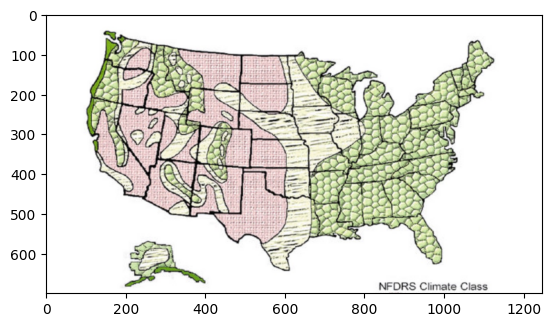

In [23]:
usa = cv2.imread('map_image.jpg')
usa =cv2.cvtColor(usa, cv2.COLOR_BGR2RGB)
plt.imshow(usa)
plt.show()

In [24]:
vectorized = usa.reshape((-1,3))
vectorized = np.float32(vectorized)

In [25]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [26]:
k = 5
attempts = 10
ret, label, center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

In [27]:
center = np.uint8(center)

In [28]:
res = center[label.flatten()]
result_image = res.reshape((usa.shape))

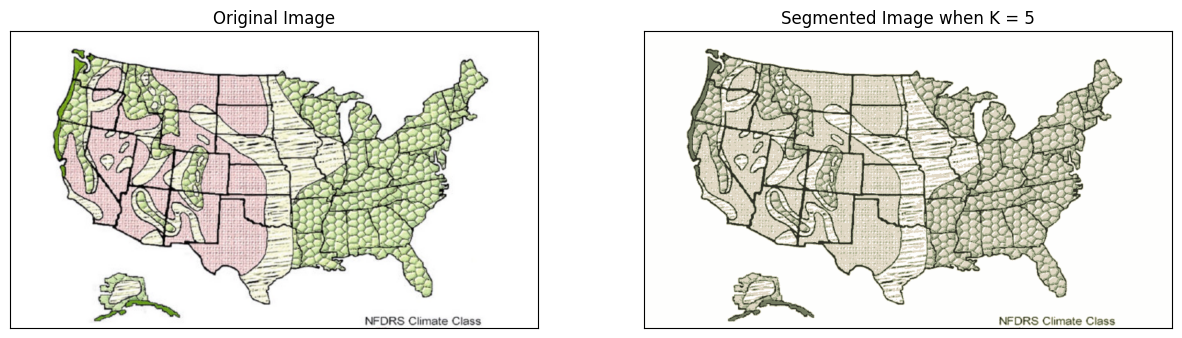

In [29]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(usa)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(result_image)
plt.title('Segmented Image when K = %i' % k), plt.xticks([]), plt.yticks([])
plt.show()


In [ ]:
edges = cv2.Canny(usa, 150, 200)
